In [ ]:
!pip install contractions

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import nltk
import pickle
import keras
import string

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from utilities import *

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

In [6]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv', usecols=['label', 'comment'])
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [7]:
df['comment'] = (df['comment']
     .str.replace(r'http\S+', 'XXURLXX', regex=True)
     .str.replace(r'\bu/\S+', 'XXUSERMENTIONXX', regex=True)
     .str.replace(r'\br/\S+', 'XXSUBREDDITMENTIONXX', regex=True)
     .str.replace(r'#[a-z0-9_]+', ' XXHASHTAGXX ', regex=True)
     .str.replace(r'\b\d+\b', 'XXNUMBERXX', regex=True)
     .str.replace(r'\:\)+(?!\S)', ' XXSMILINGFACEXX ', regex=True)
     .str.replace(r'\:D+(?!\S)', ' XXSMILINGFACEXX ', regex=True)
     .str.replace(r'\;\)+(?!\S)', ' XXWINKFACEXX ', regex=True)
     .str.replace(r'\;D+(?!\S)', ' XXWINKFACEXX ', regex=True)
     .str.replace(r'\:\(+(?!\S)', ' XXSADFACEXX ', regex=True)
     .str.replace(r'\;\(+(?!\S)', ' XXSADFACEXX ', regex=True)
     .str.replace(r'<3', ' XXHEARTXX ', regex=False)
)

In [8]:
X = df['comment']
y = df['label'].values

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [10]:
X_train.shape, X_val.shape, X_test.shape

((768187,), (202155,), (40431,))

# bag of words

In [ ]:
100/X_train.shape[0]

0.0001301766366783088

In [11]:
all_sw = list(sklear_stopwords) + stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words=all_sw, token_pattern=r'(?u)\b\w\w+\b|\!|\?|\.\.\.',
                                   ngram_range=(1,3), min_df=50)
X_train_vec = count_vectorizer.fit_transform(X_train)

In [12]:
len(count_vectorizer.get_feature_names_out())

10741

In [13]:
X_val_vec = count_vectorizer.transform(X_val)
X_test_vec = count_vectorizer.transform(X_test)

In [14]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train);

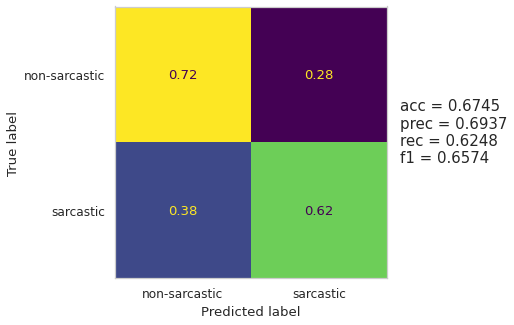

In [15]:
evaluate(mnb, X_val_vec, y_val)

In [16]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_train_vec), y_train)).shuffle(100).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_val_vec), y_val)).batch(128)

In [19]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [20]:
model = Sequential([
    InputLayer(input_shape=(X_train_vec.shape[1],)),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


6002/6002 [==============================] - 79s 12ms/step - loss: 0.6089 - accuracy: 0.6678 - val_loss: 0.5892 - val_accuracy: 0.6829
Epoch 2/50
6002/6002 [==============================] - 92s 15ms/step - loss: 0.5847 - accuracy: 0.6874 - val_loss: 0.5859 - val_accuracy: 0.6869
Epoch 3/50
6002/6002 [==============================] - 75s 13ms/step - loss: 0.5671 - accuracy: 0.7020 - val_loss: 0.5930 - val_accuracy: 0.6803
Epoch 4/50
6002/6002 [==============================] - 71s 12ms/step - loss: 0.5473 - accuracy: 0.7181 - val_loss: 0.6060 - val_accuracy: 0.6727
Epoch 5/50
6002/6002 [==============================] - 71s 12ms/step - loss: 0.5335 - accuracy: 0.7286 - val_loss: 0.6145 - val_accuracy: 0.6690


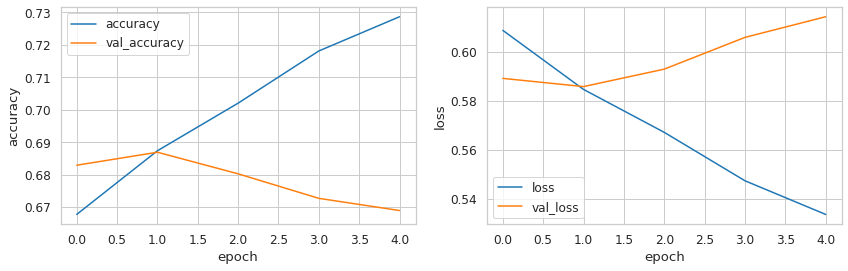

In [22]:
plot_history(fit)

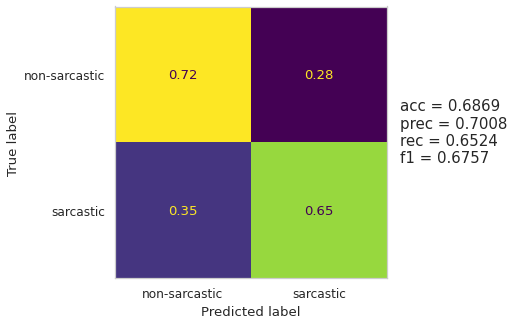

In [24]:
evaluate(model, sparse_tensor(X_val_vec), y_val)

In [25]:
show_errors(model, X_val, sparse_tensor(X_val_vec), y_val, n=5)

False negatives:
---------------------------
She'll never win the presidency now...
B-b-but thehists r dmbr
This hotdog legs craze has to stop
Heighten the contradictions, comrade.
But it is her time and I'm with her...

False positives:
---------------------------
...every QB will be available at XXNUMBERXX.
Or he found some images of the champion while Riot was working on it and posted it as his
I doubt the mainstream media will give him airtime, as it would negate the "old white racist" NRA stereotype that they've been pushing for decades.
I mean, if I do some bicep curls with anything over five pounds, I'll turn into Arnold, right?
Stats which are provided by the same police who are overtly racist.


In [26]:
model.save(root+'bag_of_words')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/bag_of_words/assets


# univariate feature selection

In [35]:
def univariate_fs(scorer, data_filename, scores_filename, k=4000):
    kbest = SelectKBest(scorer, k=4000)

    X_train = kbest.fit_transform(X_train_vec, y_train)
    X_val = kbest.transform(X_val_vec)
    X_test = kbest.transform(X_test_vec)

    data = {'X_train': X_train, 'X_val': X_test, 'X_test': X_test}

    with open(root+'univariate_fs/'+data_filename, 'wb') as file:
        pickle.dump(data, file)

    df_scores = pd.DataFrame({
        'feature': count_vectorizer.get_feature_names_out(),
        'score': kbest.scores_
    })
    
    df_scores = df_scores.sort_values('score', ascending=False, ignore_index=True)
    df_scores.to_csv(root+fr'univariate_fs/{scores_filename}.csv', index=False)

    return df_scores

## mutual info

In [37]:
mi_scores = univariate_fs(mutual_info_classif, 'mi_data', 'mi_scores')

In [38]:
mi_scores.head(20)

,feature,score
0,!,0.009905
1,yeah,0.007367
2,obviously,0.003707
3,forgot,0.003323
4,totally,0.002889
5,clearly,0.002324
6,racist,0.001420
7,xxsmilingfacexx,0.001268
8,yes,0.001172
9,wow,0.001130


In [ ]:
# data_mutual_info = pickle.load(open(root+'data_mutual_info','rb'))

## chi2

In [39]:
chi2_scores = univariate_fs(chi2, 'chi2_data', 'chi2_scores')

In [40]:
chi2_scores.head(20)

,feature,score
0,!,13343.933346
1,yeah,10211.042996
2,obviously,4936.548142
3,forgot,4382.854804
4,totally,3945.953809
5,clearly,3160.668544
6,xxnumberxx,2197.115963
7,racist,1977.263443
8,xxsmilingfacexx,1754.470000
9,right,1671.863524


## anova f-value

In [41]:
f_scores = univariate_fs(f_classif, 'f_data', 'f_scores')

In [42]:
f_scores.head(20)

,feature,score
0,!,14124.608421
1,yeah,10697.012750
2,obviously,4986.986626
3,forgot,4442.318787
4,totally,3914.063272
5,clearly,3163.763582
6,racist,1876.004439
7,xxsmilingfacexx,1691.795996
8,right,1646.488584
9,yes,1612.675354
